<a href="https://colab.research.google.com/github/rushikram/mlprojects/blob/main/Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --quiet transformers huggingface_hub bitsandbytes accelerate sentencepiece gradio

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import T5Tokenizer, T5ForConditionalGeneration

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import gradio as gr


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:


df = pd.read_csv('/content/airline.csv')

In [9]:
df.sample(10, random_state=1)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
15278,569123565984997376,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,franchise02,NaN,0.0,@USAirways any guesstimate on hold times? Can'...,NaN,2015-02-21 05:16:46 -0800,NaN,Eastern Time (US & Canada)
15526,568814284680994816,negative,1.0,Customer Service Issue,0.6485,US Airways,NaN,CLChicosky,NaN,0.0,@sarahpompei don't bother wasting your time! ...,NaN,2015-02-20 08:47:48 -0800,NaN,NaN
10787,568204029517553665,neutral,0.6879,NaN,0.0,Southwest,NaN,ericcox122685,NaN,0.0,@SouthwestAir I will be writing in about the s...,NaN,2015-02-18 16:22:52 -0800,NaN,Central Time (US & Canada)
183,569318130356502528,positive,0.3579,NaN,0.0,Virgin America,NaN,miaerolinea,NaN,0.0,😎 RT @VirginAmerica: You’ve met your match. Go...,NaN,2015-02-21 18:09:54 -0800,Worldwide,Caracas
1906,569526172335222784,neutral,1.0,NaN,NaN,United,NaN,ATL_Attorney,NaN,0.0,@united same day flights,NaN,2015-02-22 07:56:35 -0800,"Atlanta, GA",Quito
23809,569766247715319808,negative,1.0,Cancelled Flight,1.0,American,NaN,sam4tgl,NaN,1.0,@AmericanAir flight Cancelled Flighted! I'm tr...,NaN,2015-02-22 23:50:33 -0800,Pride Rock,Pacific Time (US & Canada)
13260,568128390487789568,positive,1.0,NaN,NaN,Delta,NaN,GnarlsGnarley,NaN,0.0,@JetBlue thanks. Line moved quick. Already done.,NaN,2015-02-18 11:22:18 -0800,The Suite Lounge,Eastern Time (US & Canada)
6649,567744948934426625,negative,0.6632,Customer Service Issue,0.6632,Southwest,NaN,beccalauren2011,NaN,0.0,@SouthwestAir Trying to add my dog on the flig...,NaN,2015-02-17 09:58:38 -0800,"SMALL TOWN, USA",Central Time (US & Canada)
13704,570272309434564608,negative,0.6875,Lost Luggage,0.3542,US Airways,NaN,RyanDrinks42,NaN,2.0,.@USAirways I did but the more eyes I have loo...,NaN,2015-02-24 09:21:28 -0800,Just outside of Thunder Dome,Eastern Time (US & Canada)
8320,568489124098924546,negative,0.6596,Can't Tell,0.3521,Delta,NaN,alanbestnyc,NaN,0.0,"@JetBlue No, it didn't all work out. I called ...",NaN,2015-02-19 11:15:43 -0800,NaN,Quito


In [10]:
data = df.copy()

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
retweet_count,24787.0,0.079356,0.795394,0.0,0.0,0.0,0.0,44.0


In [12]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


In [13]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )
        else:
            label = p.get_height()

        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<ipython-input-13-adb2c2d61612>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


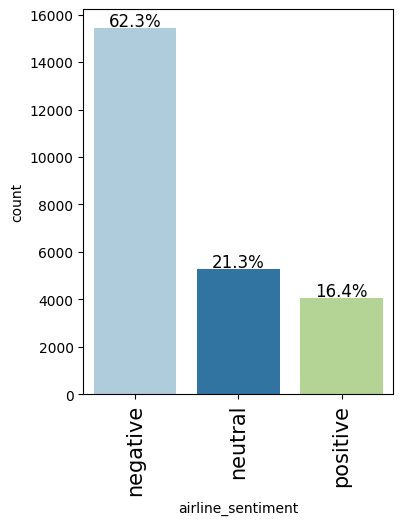

In [14]:
labeled_barplot(data, "airline_sentiment", perc=True)

<ipython-input-13-adb2c2d61612>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


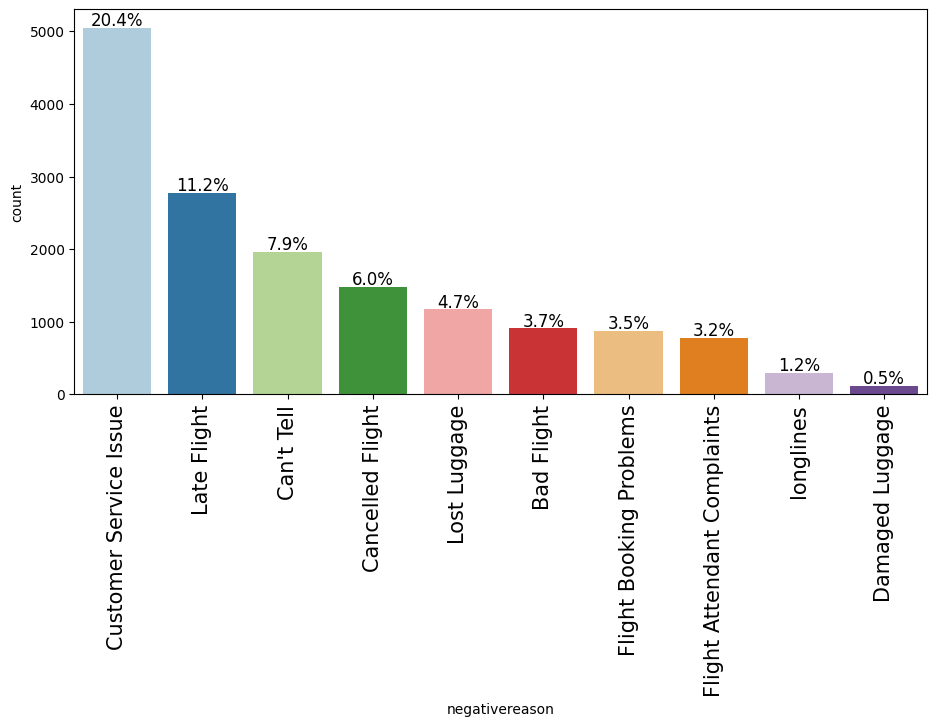

In [15]:
labeled_barplot(data, "negativereason", perc=True, n=10)

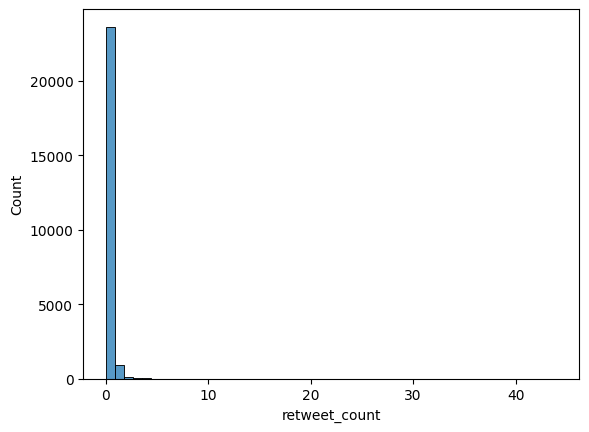

In [16]:
sns.histplot(data, x='retweet_count', bins =50);

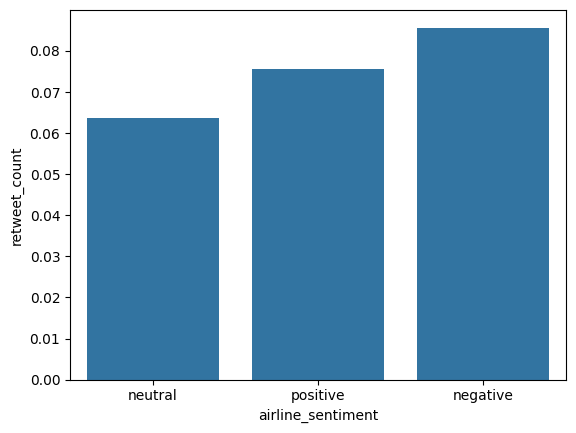

In [17]:
sns.barplot(data, y='retweet_count', x='airline_sentiment', errorbar=('ci', False));


In [18]:

X = data.drop('airline_sentiment', axis=1)
y = data['airline_sentiment']


X_validation, X_test, y_validation, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
text_column_validation = X_validation['text'].copy()
actual_sentiment_validation = y_validation.copy()

In [20]:
text_column_test = X_test['text'].copy()
actual_sentiment_test = y_test.copy()

In [21]:
!pip install -U bitsandbytes
!pip install accelerate
# Restart the kernel after running this cell. You can do this by going to "Kernel" -> "Restart" in the notebook menu.

In [22]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
# After kernel restart, run the code to load the model
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large",  device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [23]:
def llm_response(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cpu")
    outputs = model.generate(input_ids, max_length=300, do_sample=True, temperature=0.1)
    return tokenizer.decode(outputs[0])[6:-4]

In [24]:
print(text_column_validation[4])
print(actual_sentiment_validation[4])

@VirginAmerica and it's a really big bad thing about it
negative


In [25]:
sys_prompt = """
    Categorize the sentiment of the customer review as positive, negative, or neutral.
"""

pred_sent = llm_response(
    """
        {}
        Review text: '{}'
    """.format(sys_prompt, text_column_validation[4])
)

print(pred_sent)

pred_sent = llm_response(
    """
        {}
        Review text: '{}'
    """.format(sys_prompt, text_column_validation[4])
)

print(pred_sent)

negative
negative


In [26]:
def predict_sentiment(review_text):
    pred = llm_response(
        """
            {}
            Review text: '{}'
        """.format(sys_prompt, review_text)
    )

    return pred

In [50]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predicted_sentiment(text):

    model = ...
    model.to(device)
    with torch.no_grad():
        inputs = ...
        outputs = model(inputs.to(device))
    return outputs


In [51]:
df_combined = pd.concat([text_column_validation, actual_sentiment_validation], axis=1)
df_combined['predicted_sentiment'] = predicted_sentiment
df_combined.head()

,text,airline_sentiment,predicted_sentiment
22025,@AmericanAir We don't mind the fee! We were to...,negative,<function predicted_sentiment at 0x7be3d7a0b6d0>
11832,@JetBlue no. come on.,neutral,<function predicted_sentiment at 0x7be3d7a0b6d0>
1812,@united your website is fucked up. Now instead...,negative,<function predicted_sentiment at 0x7be3d7a0b6d0>
1788,@united Are your earnings so low that checkin ...,negative,<function predicted_sentiment at 0x7be3d7a0b6d0>
383,"@VirginAmerica, I submitted a status match req...",negative,<function predicted_sentiment at 0x7be3d7a0b6d0>


In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score

df_combined['airline_sentiment'] = df_combined['airline_sentiment'].astype(str)
df_combined['predicted_sentiment'] = df_combined['predicted_sentiment'].astype(str)

df_combined = df_combined.dropna(subset=['airline_sentiment', 'predicted_sentiment'])


cnf_mt = confusion_matrix(
    df_combined['airline_sentiment'],
    df_combined['predicted_sentiment'],
    labels=['positive', 'neutral', 'negative'],
)

acc_tuned = accuracy_score(
    df_combined['airline_sentiment'],
    df_combined['predicted_sentiment']
)

print("Confusion Matrix:\n", cnf_mt)
print("Accuracy:", acc_tuned)



Confusion Matrix:
 [[0 0 0]
 [0 0 0]
 [0 0 0]]
Accuracy: 0.0


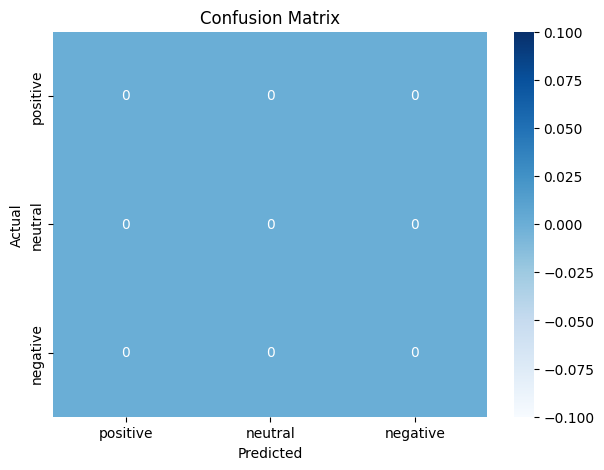

In [54]:

plt.figure(figsize=(7, 5))
sns.heatmap(
    cnf_mt,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['positive', 'neutral', 'negative'],
    yticklabels=['positive', 'neutral', 'negative'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [55]:
sys_prompt = """
    Categorize the sentiment of the customer review as positive, negative, or neutral.
    Leverage your expertise in the aviation industry and deep understanding of industry trends to analyze the nuanced expressions and overall tone.
    It is crucial to accurately identify neutral sentiments, which may indicate a balanced view or neutral stance towards Us Airways. Neutral expressions could involve factual statements without explicit positive or negative opinions.
    Consider the importance of these neutral sentiments in gauging the public sentiment towards the airline company.
    For instance, a positive sentiment might convey satisfaction with the airline's services, a negative sentiment could express dissatisfaction, while neutral sentiment may reflect an impartial observation or a neutral standpoint
"""

In [56]:
pred_sent = llm_response(
    """
        {}
        Review text: '{}'
    """.format(sys_prompt, text_column_validation[4])
)

print(pred_sent)

negative


In [57]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predicted_sentiment(text):
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large",  device_map="auto")
    model.to(device)

    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=300, do_sample=True, temperature=0.1)

    return tokenizer.decode(outputs[0])[6:-4]

In [58]:
df_combined = pd.concat([text_column_validation, actual_sentiment_validation], axis=1)
df_combined['predicted_sentiment'] = predicted_sentiment
df_combined.head()

,text,airline_sentiment,predicted_sentiment
22025,@AmericanAir We don't mind the fee! We were to...,negative,<function predicted_sentiment at 0x7be3d79eff40>
11832,@JetBlue no. come on.,neutral,<function predicted_sentiment at 0x7be3d79eff40>
1812,@united your website is fucked up. Now instead...,negative,<function predicted_sentiment at 0x7be3d79eff40>
1788,@united Are your earnings so low that checkin ...,negative,<function predicted_sentiment at 0x7be3d79eff40>
383,"@VirginAmerica, I submitted a status match req...",negative,<function predicted_sentiment at 0x7be3d79eff40>


In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score


df_combined['airline_sentiment'] = df_combined['airline_sentiment'].astype(str)
df_combined['predicted_sentiment'] = df_combined['predicted_sentiment'].astype(str)


df_combined = df_combined.dropna(subset=['airline_sentiment', 'predicted_sentiment'])


valid_labels = ['positive', 'neutral', 'negative']

print("Unique labels in airline_sentiment:", df_combined['airline_sentiment'].unique())
df_combined['airline_sentiment'] = df_combined['airline_sentiment'].apply(lambda label: label if label in valid_labels else 'unknown')  # Replace invalid labels with 'unknown' or another suitable label



print("Unique labels in predicted_sentiment:", df_combined['predicted_sentiment'].unique())

df_combined['predicted_sentiment'] = df_combined['predicted_sentiment'].apply(lambda label: label if label in valid_labels else 'unknown')  # Replace invalid labels with 'unknown' or another suitable label

cnf_mt_tuned = confusion_matrix(
    df_combined['airline_sentiment'],
    df_combined['predicted_sentiment'],
    labels=valid_labels,
)

acc_tuned = accuracy_score(
    df_combined['airline_sentiment'],
    df_combined['predicted_sentiment']
)

print("Confusion Matrix:\n", cnf_mt_tuned)
print("Accuracy:", acc_tuned)

Unique labels in airline_sentiment: ['negative' 'neutral' 'positive' 'unknown']
Unique labels in predicted_sentiment: ['unknown']
Confusion Matrix:
 [[0 0 0]
 [0 0 0]
 [0 0 0]]
Accuracy: 4.482495853691335e-05


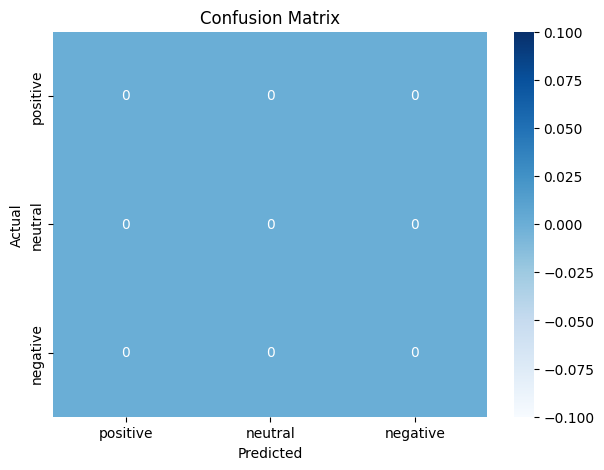

In [65]:

plt.figure(figsize=(7, 5))
sns.heatmap(
    cnf_mt_tuned,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['positive', 'neutral', 'negative'],
    yticklabels=['positive', 'neutral', 'negative'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [71]:
def predict_sentiment(review):
    sys_prompt = """
        Categorize the sentiment of the customer review as positive, negative, or neutral.
        Leverage your expertise in the aviation industry and deep understanding of industry trends to analyze the nuanced expressions and overall tone.
        It is crucial to accurately identify neutral sentiments, which may indicate a balanced view or neutral stance towards Us Airways. Neutral expressions could involve factual statements without explicit positive or negative opinions.
        Consider the importance of these neutral sentiments in gauging the public sentiment towards the airline company.
        For instance, a positive sentiment might convey satisfaction with the airline's services, a negative sentiment could express dissatisfaction, while neutral sentiment may reflect an impartial observation or a neutral standpoint
    """
    pred_sent = llm_response(
        """
            {}
            Review text: '{}'
        """.format(sys_prompt, review)
    )

    return pred_sent

In [72]:
df_combined = pd.concat([text_column_test, actual_sentiment_test], axis=1)
df_combined['predicted_sentiment'] = predicted_sentiment
df_combined.head()

,text,airline_sentiment,predicted_sentiment
3585,@united well the income flight to dca to take ...,negative,<function predicted_sentiment at 0x7be3d79eff40>
6844,@JetBlue your customer service today was deplo...,negative,<function predicted_sentiment at 0x7be3d79eff40>
16721,@AmericanAir my flight got Cancelled Flightled...,neutral,<function predicted_sentiment at 0x7be3d79eff40>
17837,@AmericanAir That will be the third time I hav...,negative,<function predicted_sentiment at 0x7be3d79eff40>
17158,@AmericanAir or at the very least an explanati...,negative,<function predicted_sentiment at 0x7be3d79eff40>


In [81]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

df_combined['airline_sentiment'] = df_combined['airline_sentiment'].astype(str)
df_combined['predicted_sentiment'] = df_combined['predicted_sentiment'].astype(str)


valid_labels = ['positive', 'neutral', 'negative', 'unknown']

df_combined = df_combined[
    df_combined['airline_sentiment'].isin(valid_labels) &
    df_combined['predicted_sentiment'].isin(valid_labels)
]

df_combined = df_combined.dropna(subset=['airline_sentiment', 'predicted_sentiment'])


cnf_mt_tuned = confusion_matrix(
    df_combined['airline_sentiment'],
    df_combined['predicted_sentiment'],
    labels=valid_labels,
)

acc_tuned = accuracy_score(
    df_combined['airline_sentiment'],
    df_combined['predicted_sentiment']
)

cnf_mt_df = pd.DataFrame(
    cnf_mt_tuned,
    index=[f"True {label}" for label in valid_labels],
    columns=[f"Pred {label}" for label in valid_labels]
)

print("Confusion Matrix:\n", cnf_mt_df)








Confusion Matrix:
                Pred positive  Pred neutral  Pred negative  Pred unknown
True positive              0             0              0             0
True neutral               0             0              0             0
True negative              0             0              0             0
True unknown               0             0              0             0


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy: nan


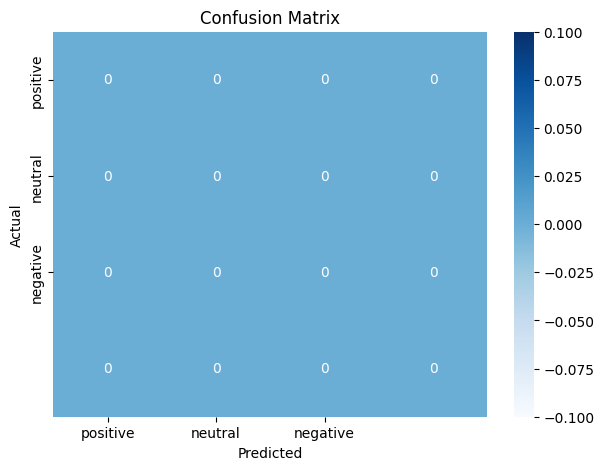

In [82]:

print("Accuracy:", acc_tuned)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cnf_mt_tuned,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['positive', 'neutral', 'negative'],
    yticklabels=['positive', 'neutral', 'negative'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [85]:
import cloudpickle

with open('clf.pkl', 'wb') as f:
    cloudpickle.dump(model, f)
with open('tfidf.pkl', 'wb') as f:
    cloudpickle.dump(tokenizer, f)

In [86]:
def predict_review_sentiment(review):
    sys_prompt = """
        Categorize the sentiment of the customer review as positive, negative, or neutral.
        Leverage your expertise in the aviation industry and deep understanding of industry trends to analyze the nuanced expressions and overall tone.
        It is crucial to accurately identify neutral sentiments, which may indicate a balanced view or neutral stance towards Us Airways. Neutral expressions could involve factual statements without explicit positive or negative opinions.
        Consider the importance of these neutral sentiments in gauging the public sentiment towards the airline company.
        For instance, a positive sentiment might convey satisfaction with the airline's services, a negative sentiment could express dissatisfaction, while neutral sentiment may reflect an impartial observation or a neutral standpoint
    """
    pred_sent = llm_response(
        """
            {}
            Review text: '{}'
        """.format(sys_prompt, review)
    )

    return pred_sent

In [87]:

review_text = gr.Textbox(label="Enter the customer sentiment here.")

sentiment = gr.Textbox(label="Sentiment Type")

In [88]:
demo = gr.Interface(
    fn=predict_review_sentiment,
    inputs = review_text,
    outputs = sentiment,
    title="Customer Review Sentiment Analyzer",
    description= "This interface will predict whether the sentiment of a customer is positive, negative, or neutral based on the review text.",
    allow_flagging="never"
)

/usr/local/lib/python3.10/dist-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


In [90]:
demo.launch(
    inline=False,
    share=True,
    debug=False
)


Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5a588e93425e87b771.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [91]:
demo.close()

Closing server running on port: 7860
